### **Context**

The original video has 78,420 frames (40 min 34 s at 30 FPS).  
To reduce redundancy, we sampled 5,000 frames by selecting 1 every ~15.7 frames (0.5 s interval).  

In this notebook, for further analysis and visualization, we picked 1 frame every 500, resulting in a temporal resolution of 4 minutes and 10 seconds between comparisons.

Every operation can be applied to droplet masks generated with:
- **Opencv segmentation** -> in code blocks _path = 'droplet_masks'_
- **Trained U-Net model** -> in code blocks _path = 'droplet_unet'_


## Droplet Subtraction Over Time

To track droplet evolution, we subtract the mask at time _n+1_ from time _n_ and preserve only the differing pixels. 

This highlights regions where the droplet shape has changed by keeping only the non-overlapping areas.

From this output we calculate the volume loss in pixel percentage.

In [25]:
# Droplet masks generated with opencv segmentation
path = 'droplet_masks'

# Droplet masks generated with the trained U-Net model
#path = 'droplet_unet'

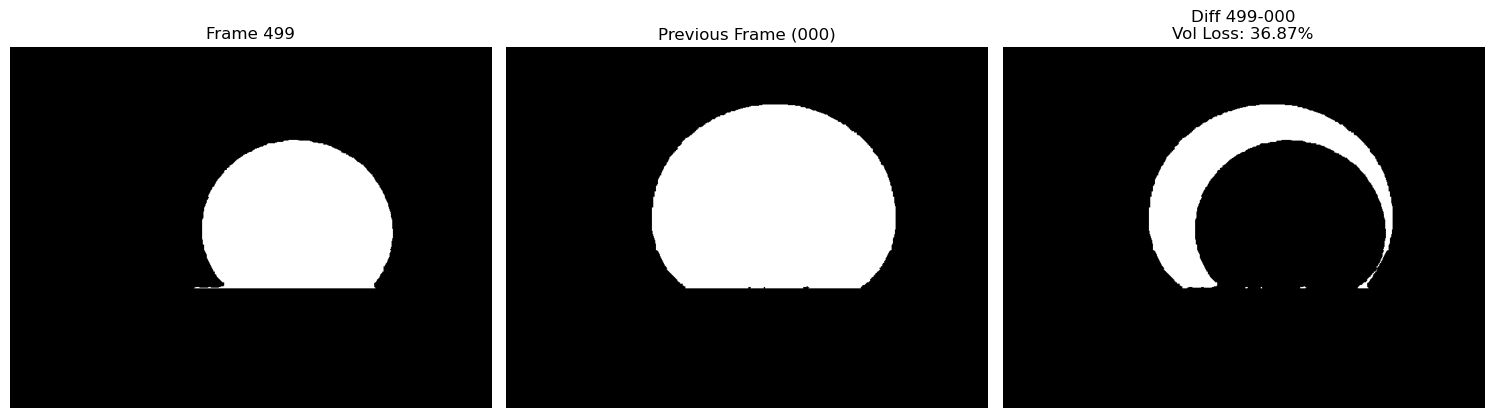

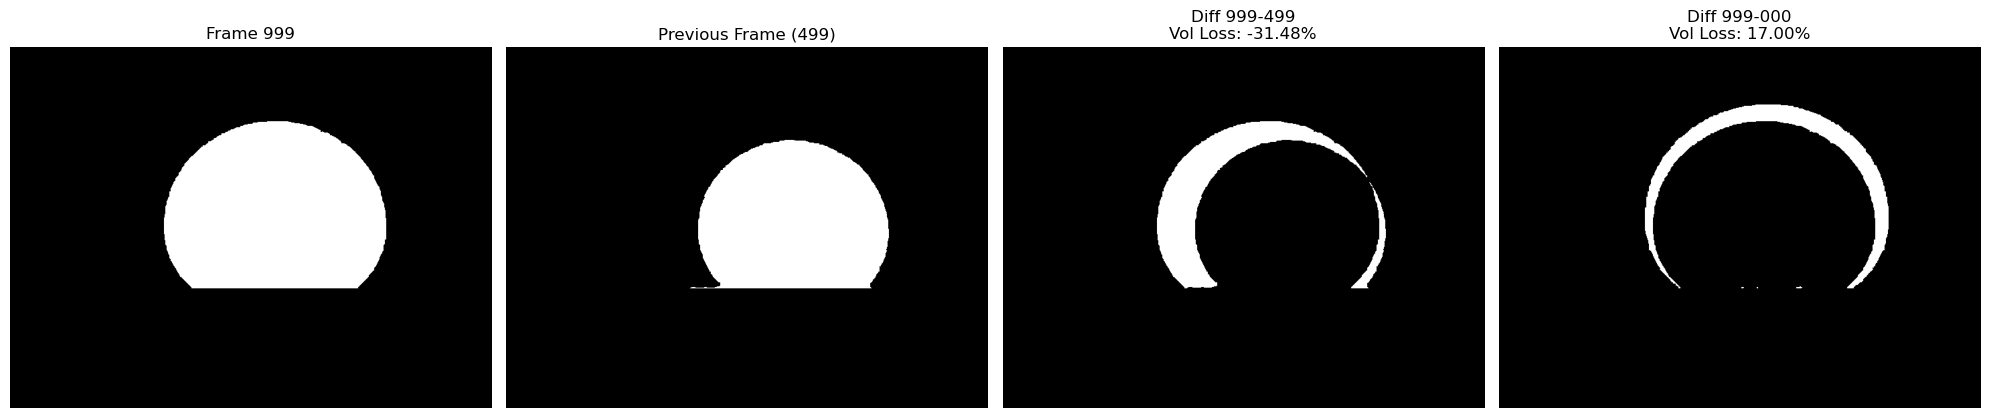

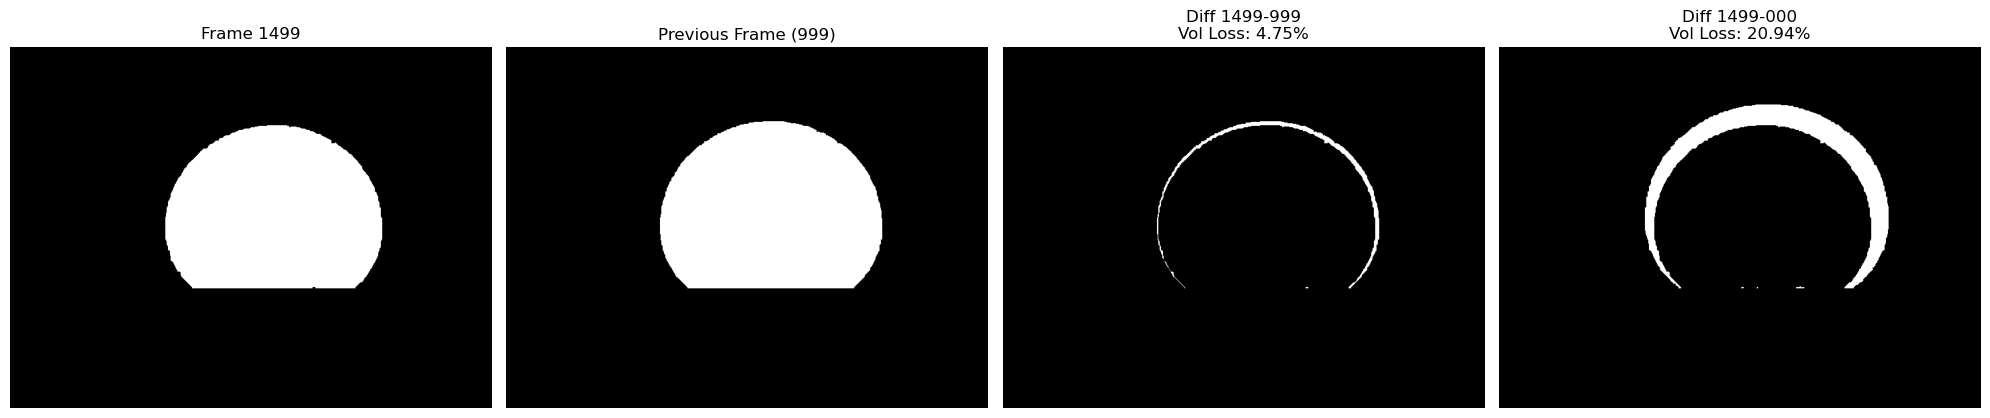

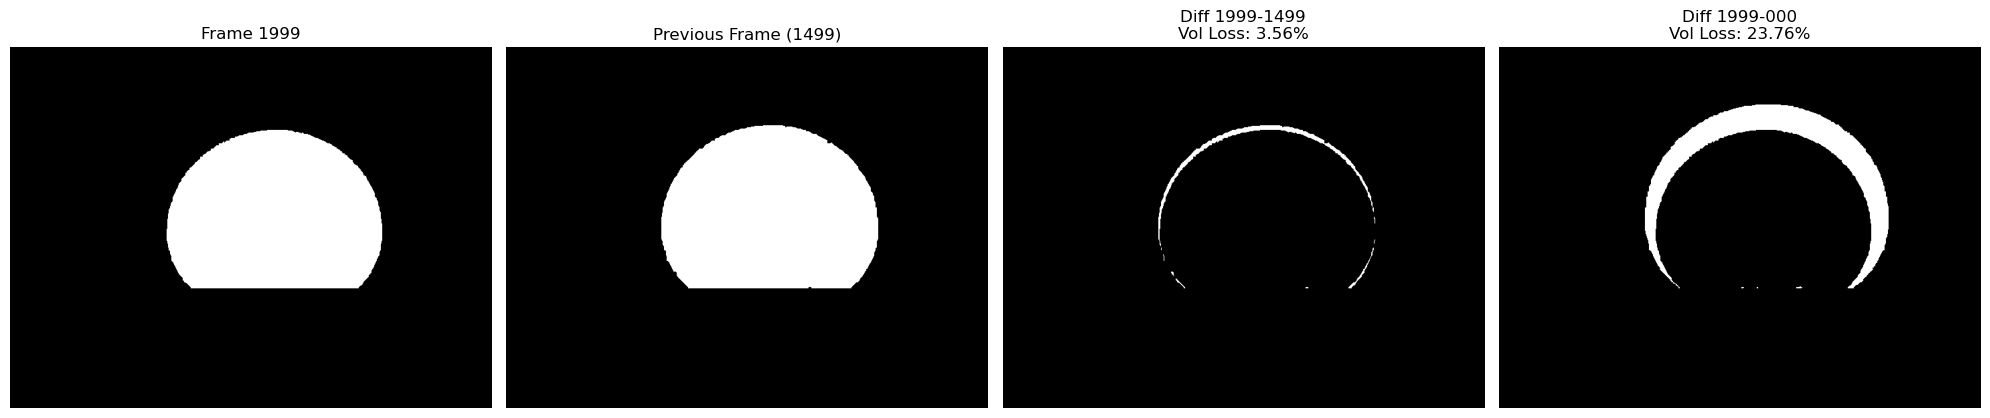

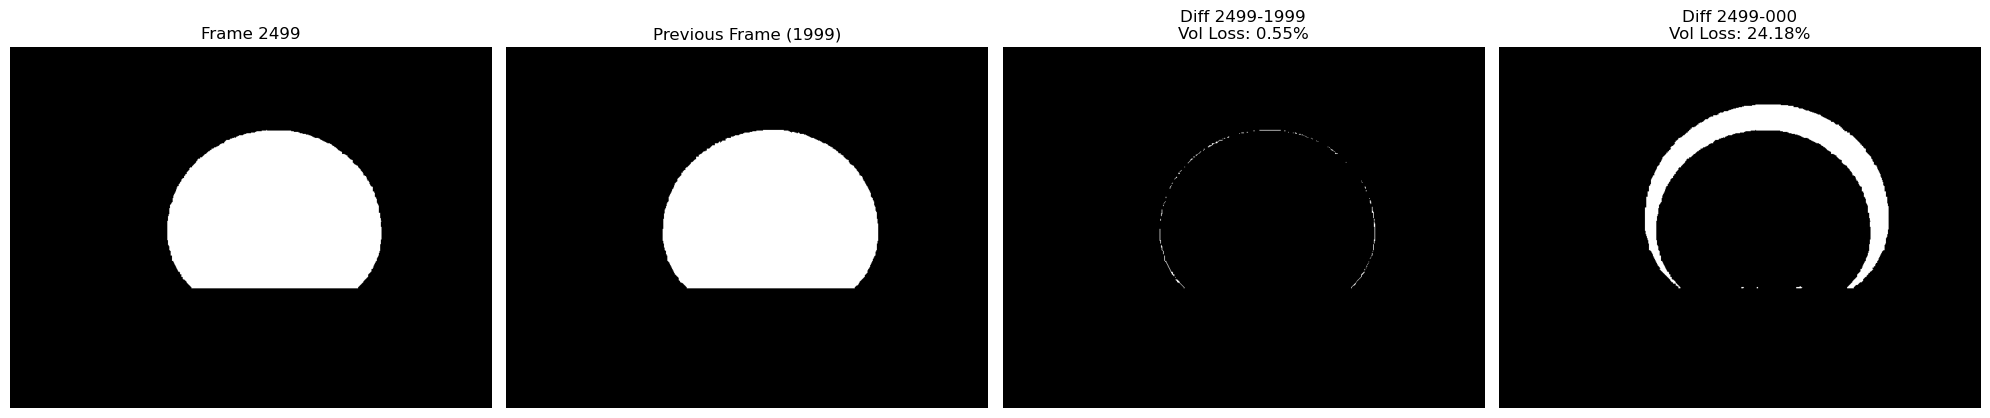

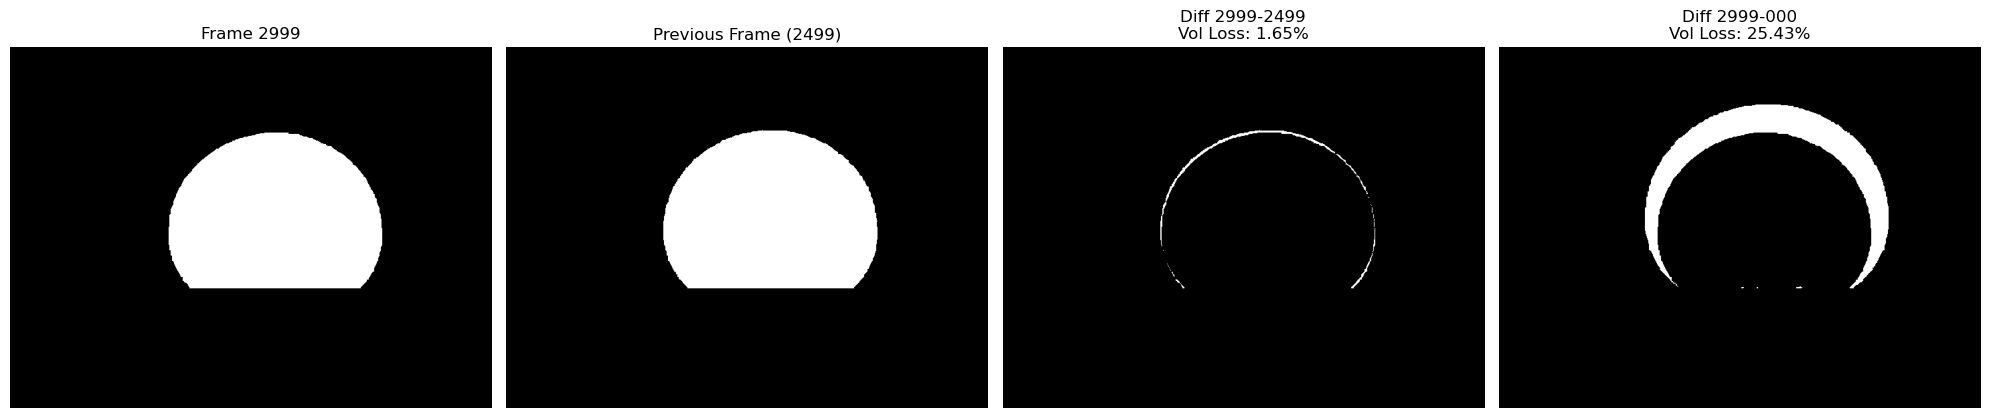

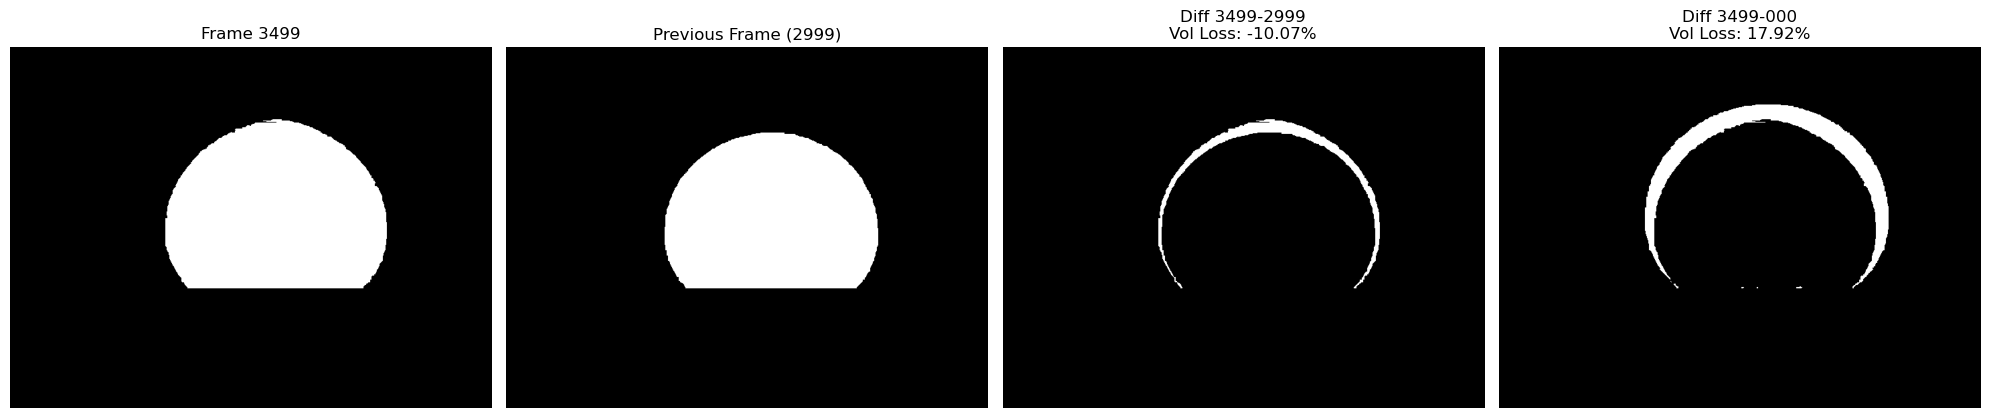

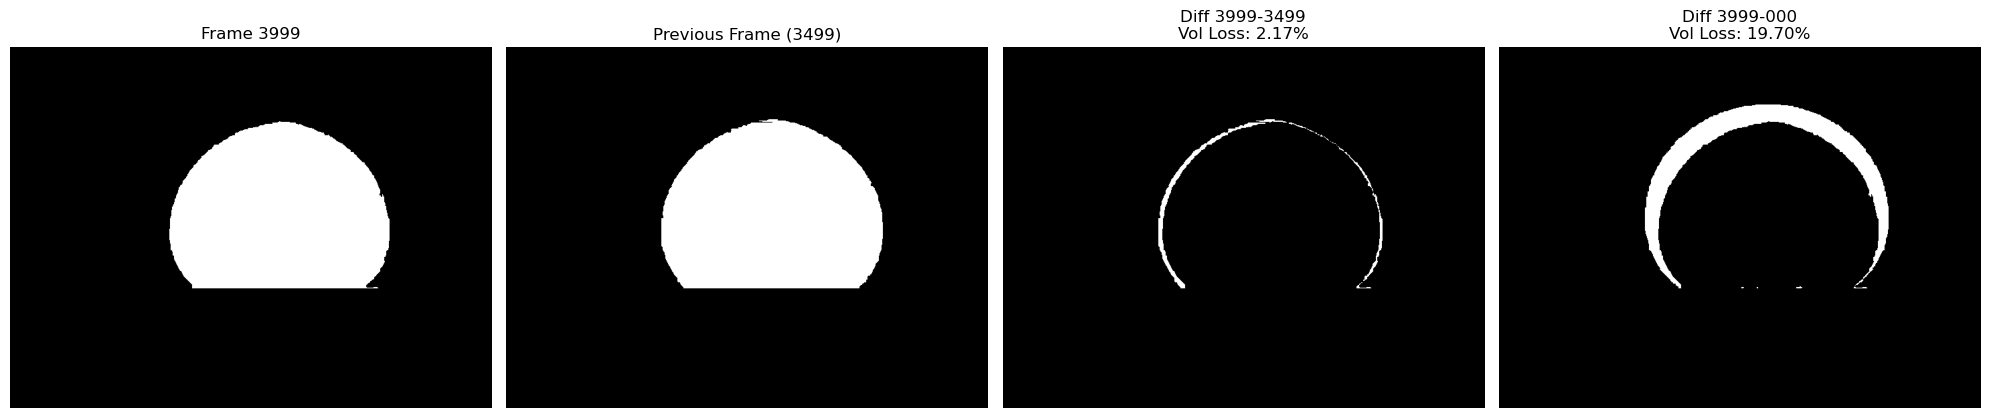

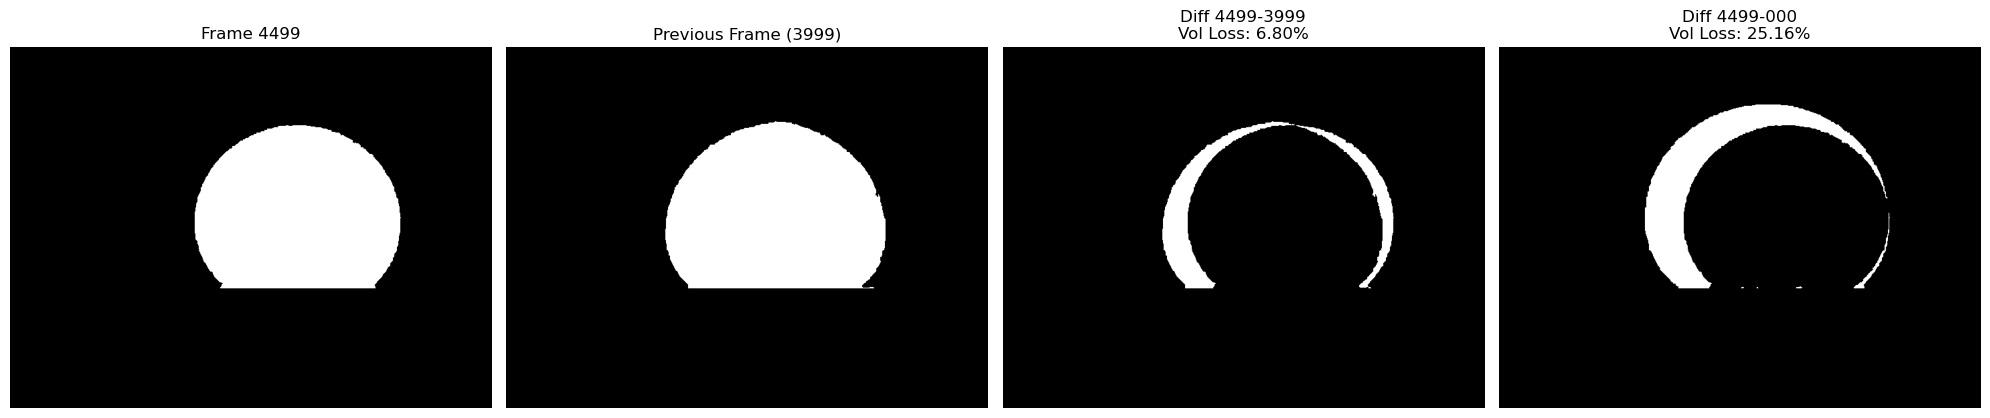

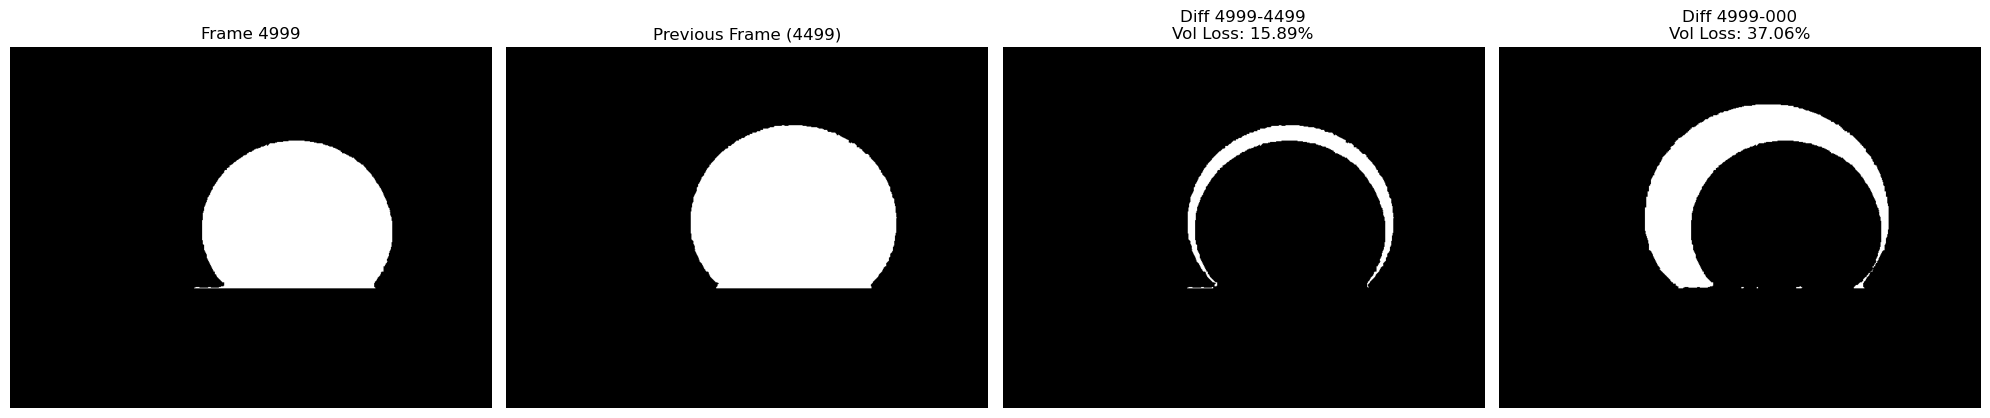

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

def filename(index):
    pattern = os.path.join(path, f'frame_{index:03d}*.png')
    return glob.glob(pattern)[0]

# Load the first frame
first_frame = cv2.imread(filename(0), cv2.IMREAD_GRAYSCALE)

# Verify loading
if first_frame is None:
    raise ValueError("First image not loaded correctly. Check the file paths.")

# Previous frame starts as first frame
prev_frame = first_frame

# Frame indices: 0, 499, ..., 4999
indices = [0] + list(range(499, 5000, 500))

for idx in indices:
    # Skip the first frame
    if idx == 0: continue

    # Load current frame
    current_frame = cv2.imread(filename(idx), cv2.IMREAD_GRAYSCALE)
    
    if current_frame is None:
        print(f"Frame {idx} could not be loaded. Skipping...")
        continue

    # Calculate differences
    diff_prev = cv2.absdiff(current_frame, prev_frame)
    diff_first = cv2.absdiff(current_frame, first_frame)

    # Calculate volume loss (in pixel percentage)
    prev_volume = np.count_nonzero(prev_frame)
    curr_volume = np.count_nonzero(current_frame)

    # Volume difference and % loss compared to previous frame
    loss_prev = (prev_volume - curr_volume) / prev_volume * 100 if prev_volume != 0 else 0

    # Volume difference and % loss compared to first frame
    first_volume = np.count_nonzero(first_frame)
    loss_first = (first_volume - curr_volume) / first_volume * 100 if first_volume != 0 else 0


    # Plotting
    plt.figure(figsize=(20, 5))

    # Current frame
    plt.subplot(1, 4, 1)
    plt.imshow(current_frame, cmap='gray')
    plt.title(f'Frame {idx:03d}')
    plt.axis('off')

    # Previous frame
    plt.subplot(1, 4, 2)
    plt.imshow(prev_frame, cmap='gray')
    plt.title(f'Previous Frame ({indices[indices.index(idx)-1]:03d})' if idx != 0 else 'N/A')
    plt.axis('off')

    # Difference with previous frame
    plt.subplot(1, 4, 3)
    plt.imshow(diff_prev, cmap='gray')
    plt.title(f'Diff {idx:03d}-{indices[indices.index(idx)-1]:03d}\nVol Loss: {loss_prev:.2f}%')
    plt.axis('off')

    # Difference with first frame
    if idx != 499:
        plt.subplot(1, 4, 4)
        plt.imshow(diff_first, cmap='gray')
        plt.title(f'Diff {idx:03d}-000\nVol Loss: {loss_first:.2f}%')
        plt.axis('off')


    plt.tight_layout()
    plt.show()

    # Update previous frame
    prev_frame = current_frame


## Bounding Box Detection
In this section we detect the droplet bounding box from the droplet masks we precedently generated. 

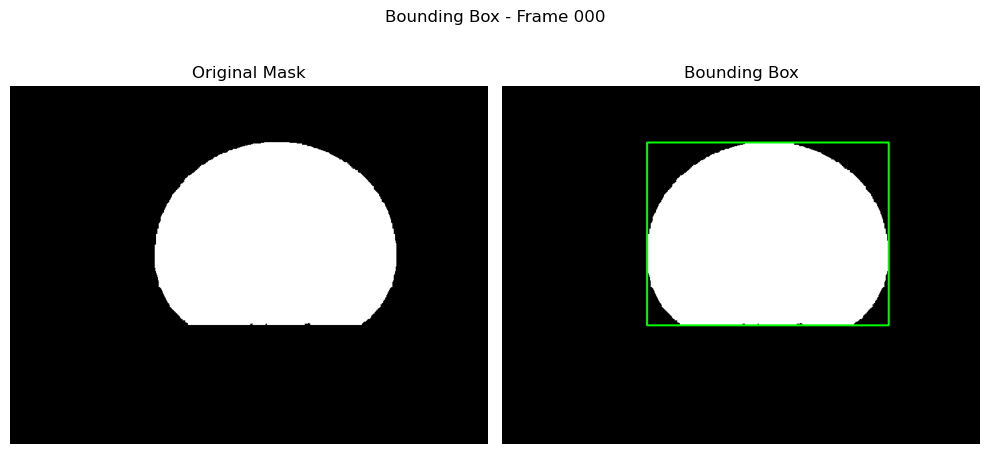

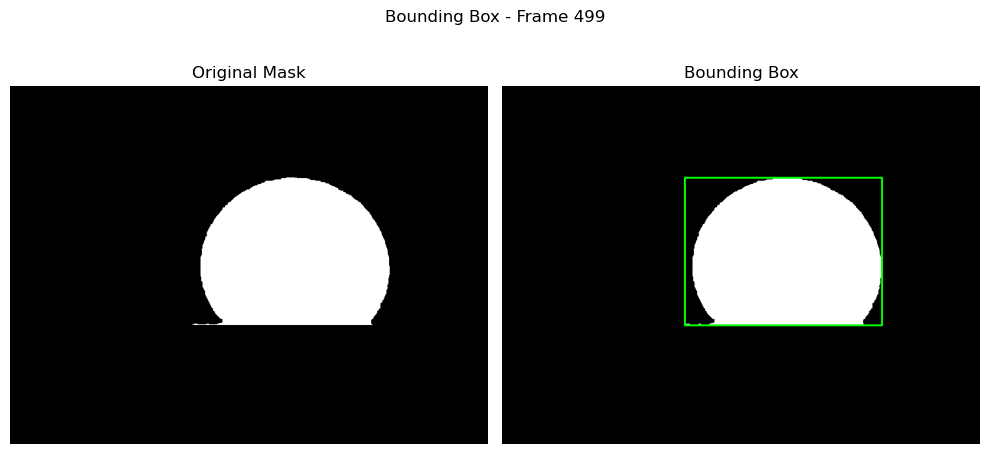

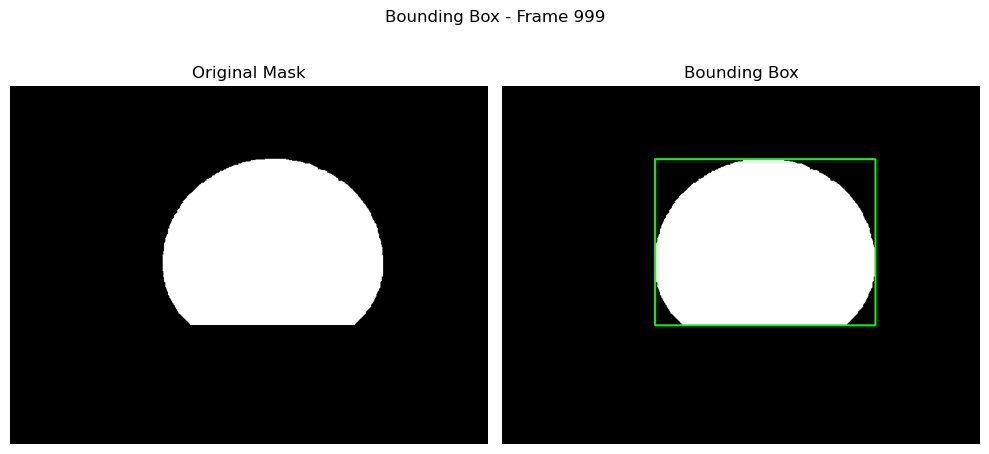

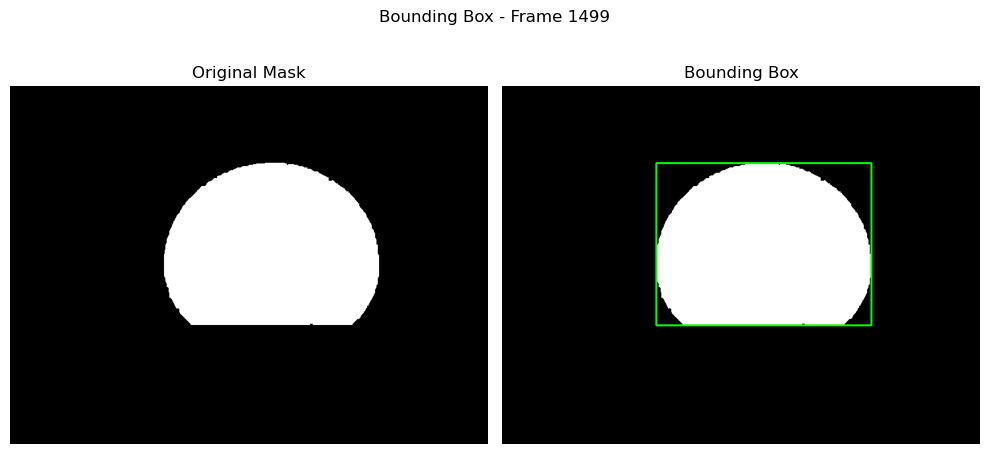

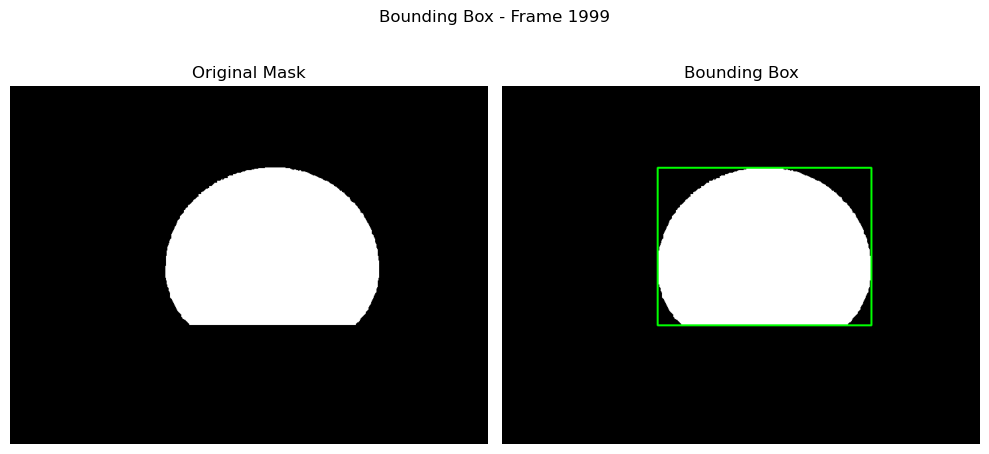

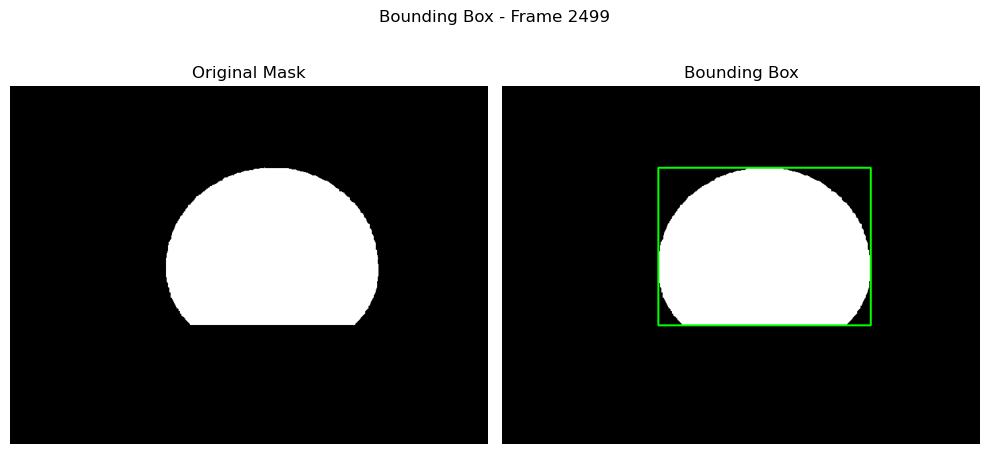

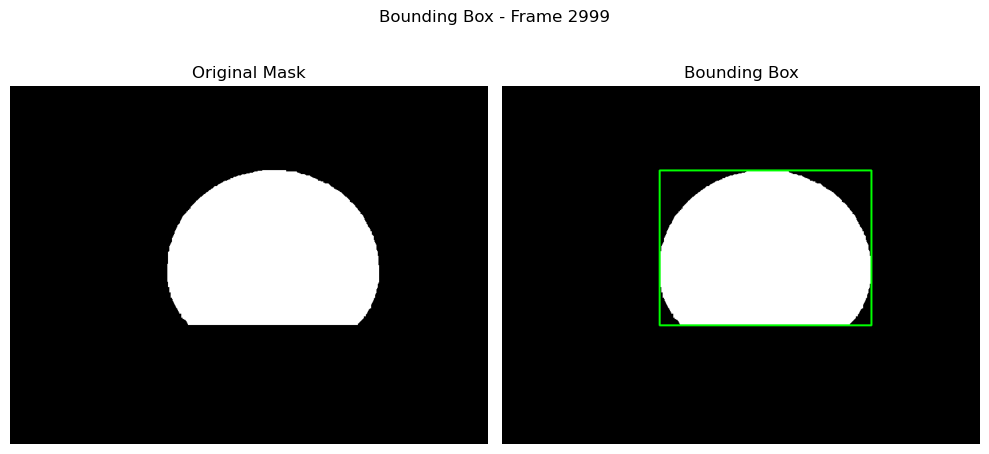

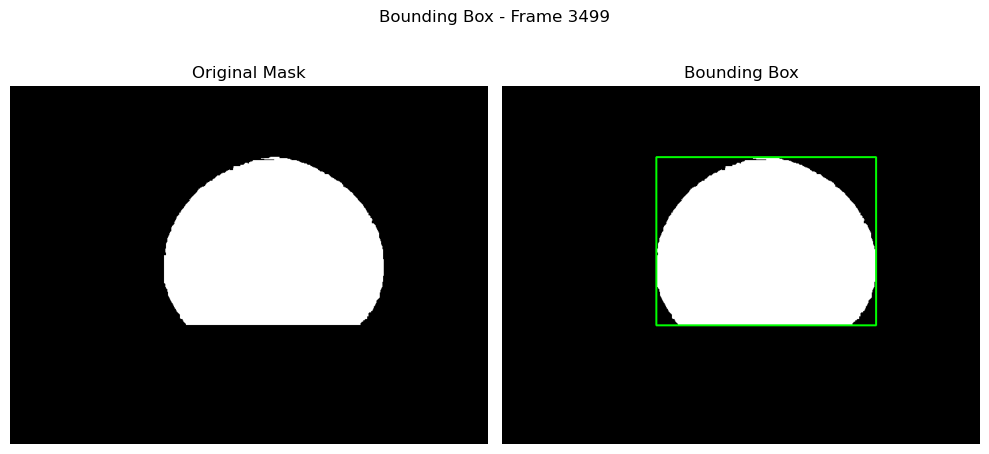

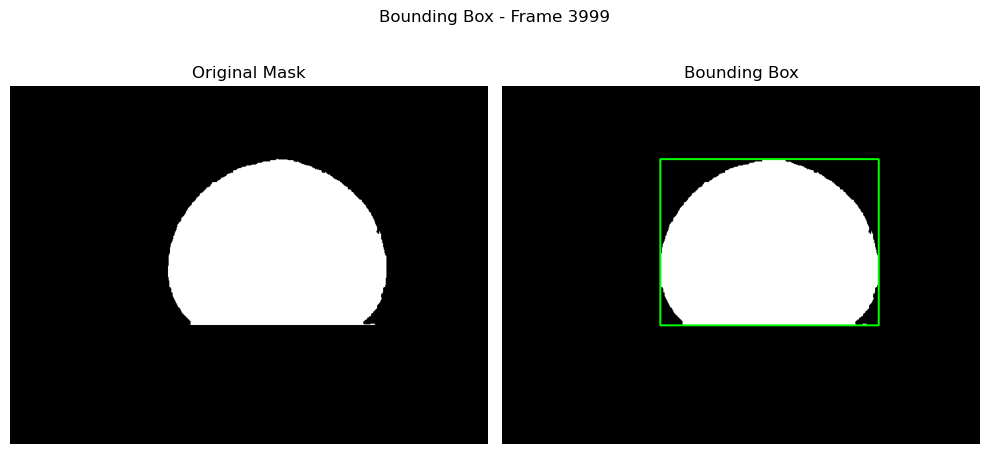

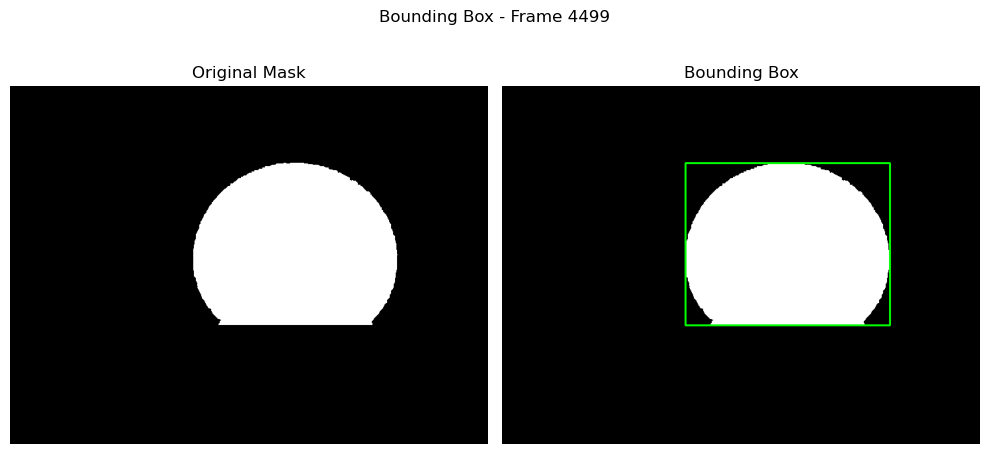

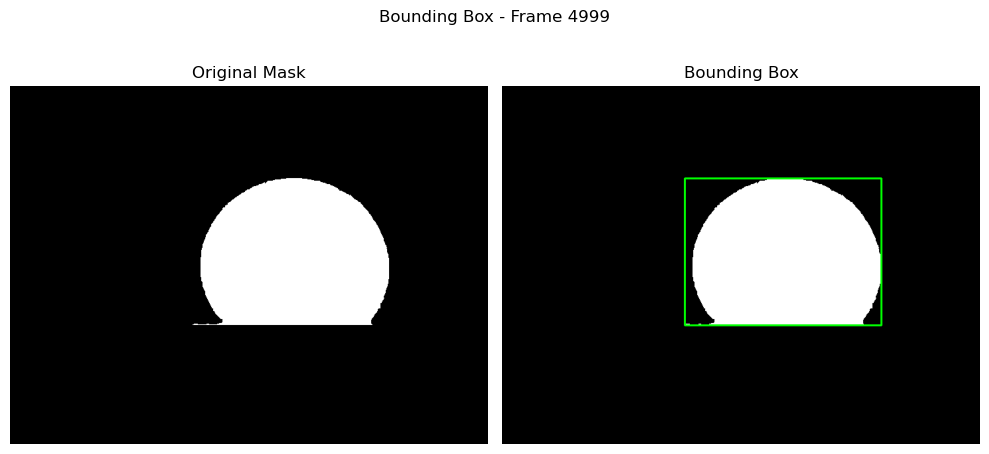

In [27]:
import cv2
import matplotlib.pyplot as plt
import os
import glob

def filename(index):
    pattern = os.path.join(path, f'frame_{index:03d}*.png')
    return glob.glob(pattern)[0]

# Process every 500 frames (e.g., 000, 499, 999, ...)
for i in range(0, 5001, 500):
    frame_idx = i if i == 0 else i - 1
    file = filename(frame_idx)
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Image {file} not found. Skipping...")
        continue

    # Threshold to binary
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print(f"No contours found in frame {frame_idx}.")
        continue

    # Get the largest contour and its bounding box
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)

    # Draw bounding box
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(img_bgr, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.suptitle(f'Bounding Box - Frame {frame_idx:03d}')

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_bgr)
    plt.title('Bounding Box')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


## Tangent Angle Estimation

For each sampled droplet mask, we compute **tangent lines** at the leftmost and rightmost intersection points between the droplet contour and the **bottom edge** of its bounding box. These tangents are derived by fitting an **ellipse** to the droplet and using the analytical expression for tangents to conic sections.

Frame 000: Intersection points = (272,360), (526,360)
            Tangent angles (horizontal) = 59.17°, 58.73°



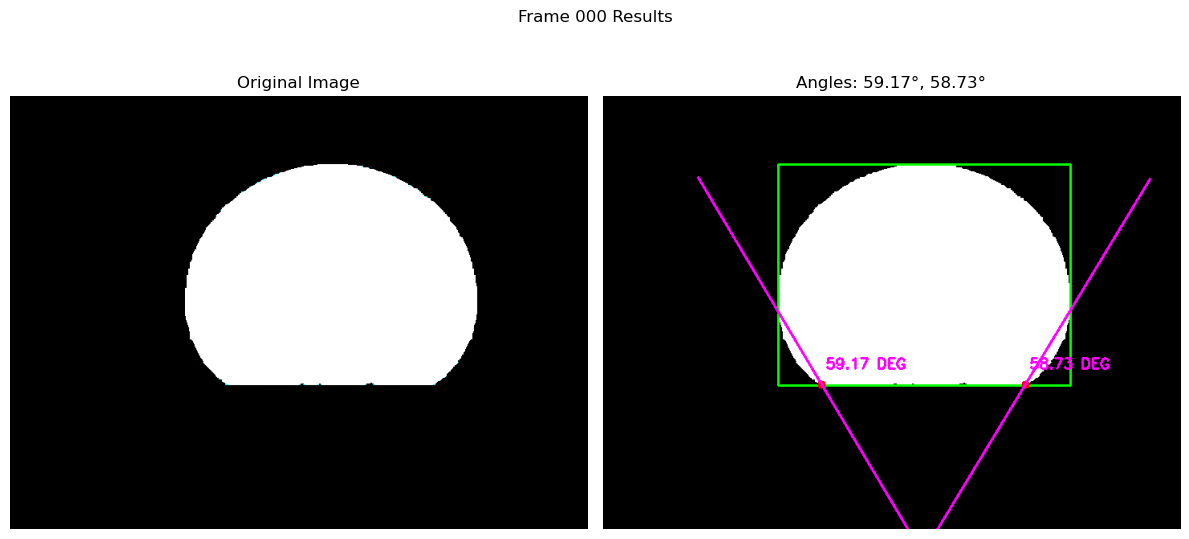

Frame 499: Intersection points = (324,360), (539,360)
            Tangent angles (horizontal) = 53.90°, 55.20°



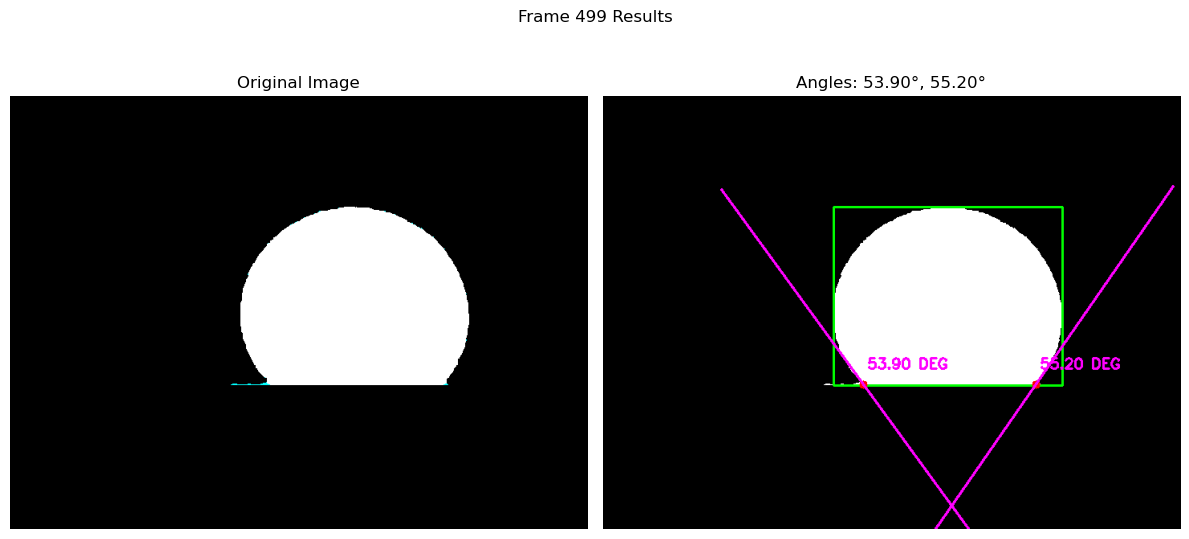

Frame 999: Intersection points = (274,360), (516,360)
            Tangent angles (horizontal) = 56.17°, 55.97°



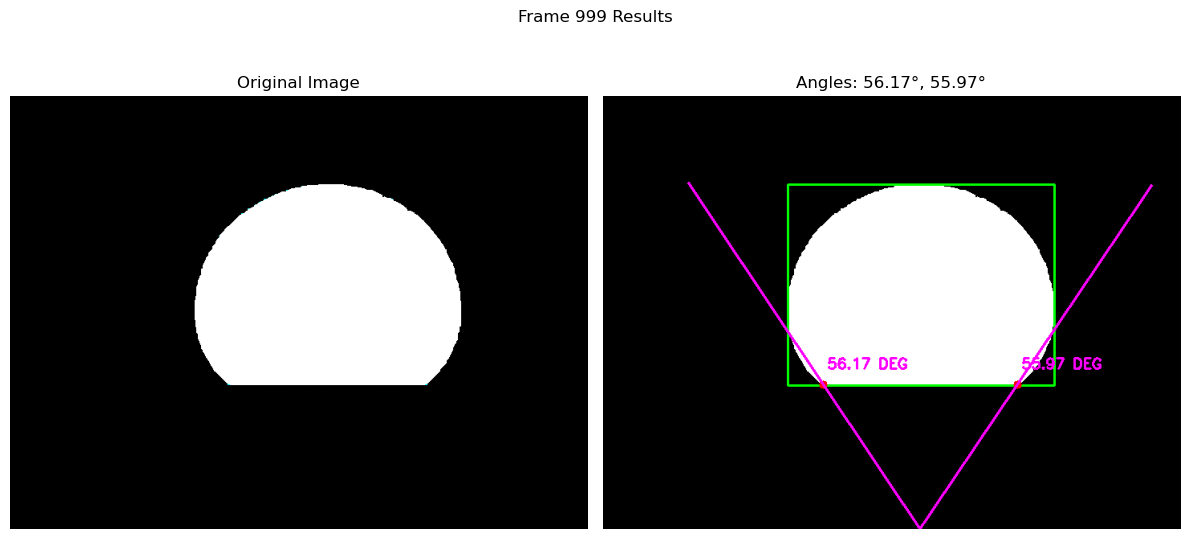

Frame 1499: Intersection points = (275,360), (512,360)
            Tangent angles (horizontal) = 57.77°, 57.75°



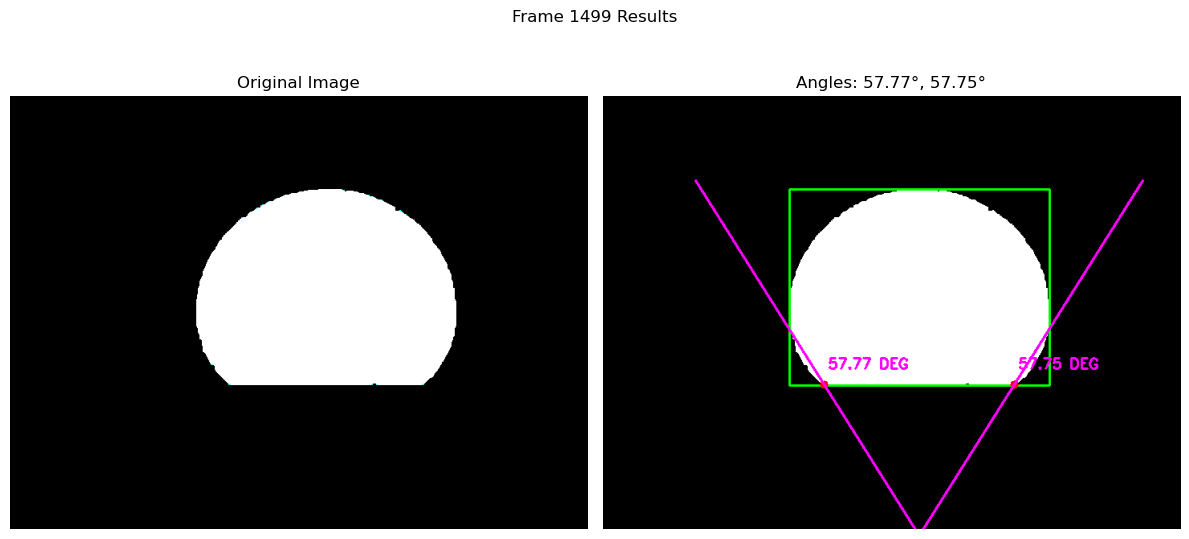

Frame 1999: Intersection points = (273,360), (517,360)
            Tangent angles (horizontal) = 58.52°, 58.62°



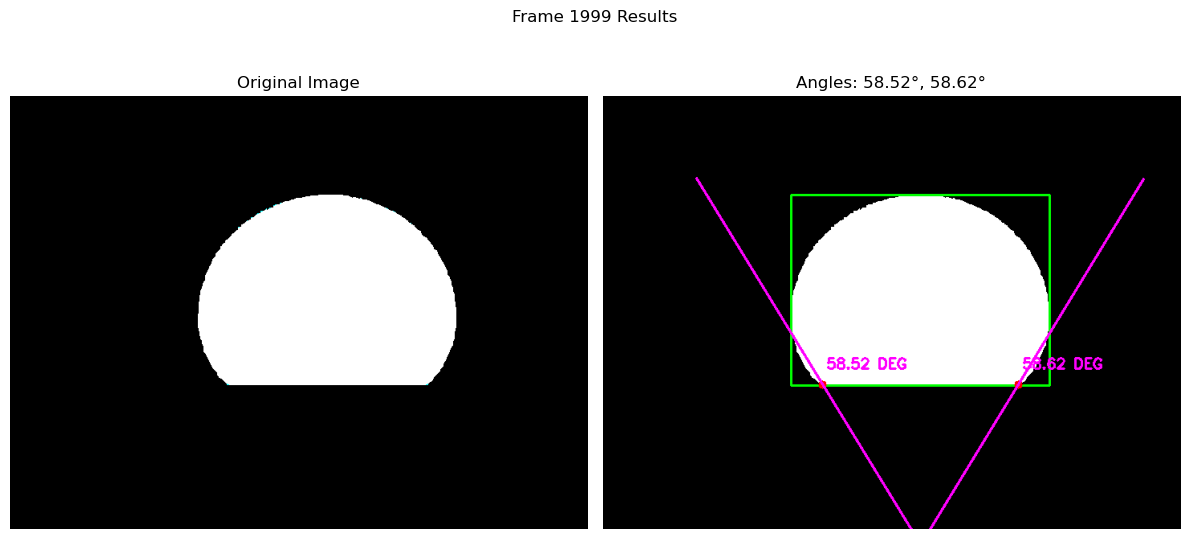

Frame 2499: Intersection points = (274,360), (516,360)
            Tangent angles (horizontal) = 58.28°, 58.34°



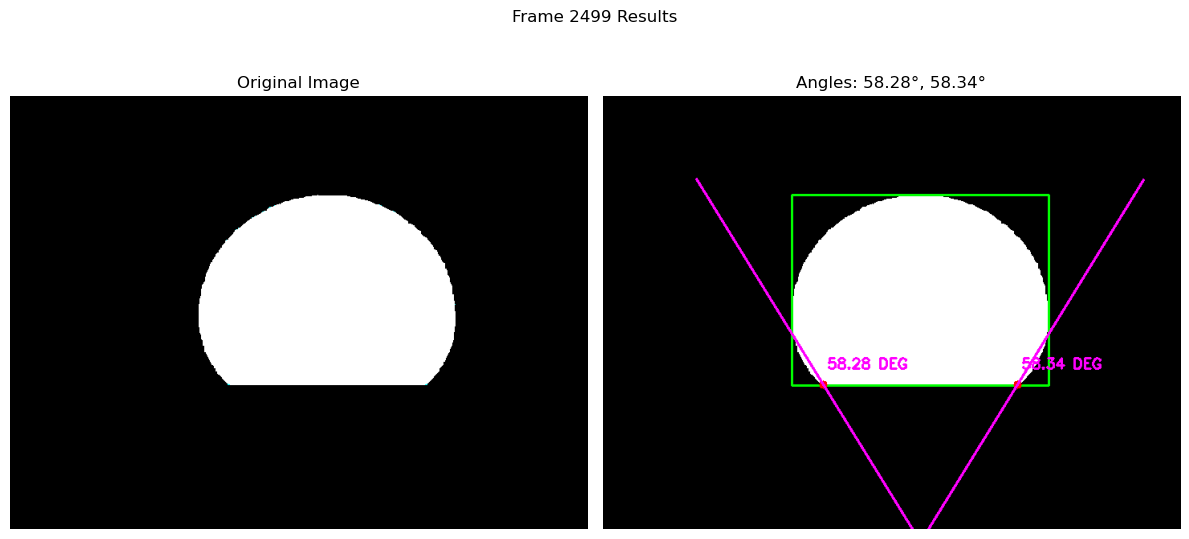

Frame 2999: Intersection points = (271,360), (520,360)
            Tangent angles (horizontal) = 60.06°, 59.89°



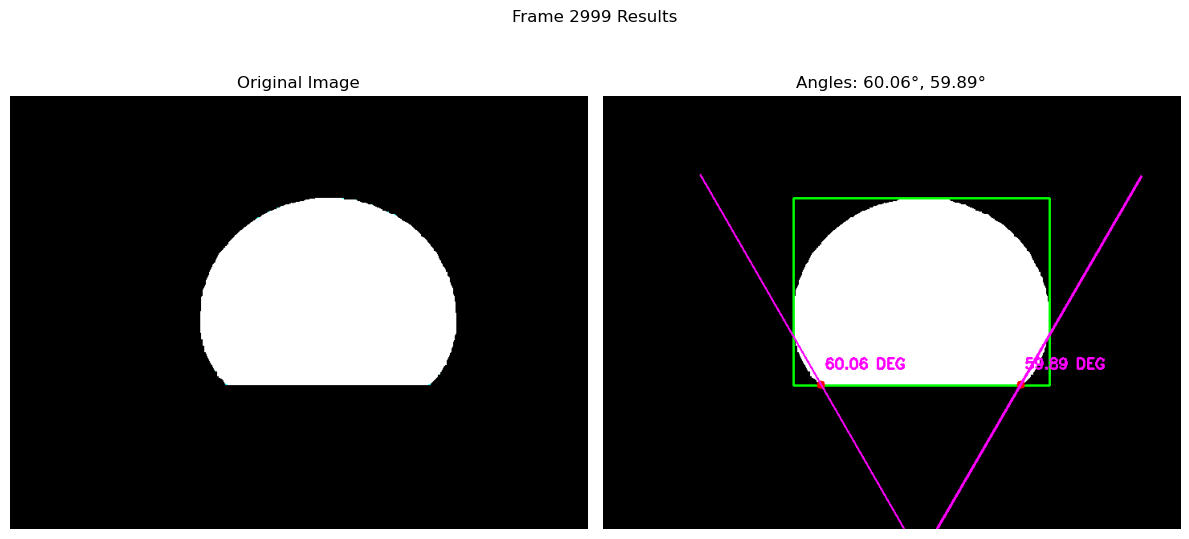

Frame 3499: Intersection points = (268,360), (523,360)
            Tangent angles (horizontal) = 57.36°, 56.77°



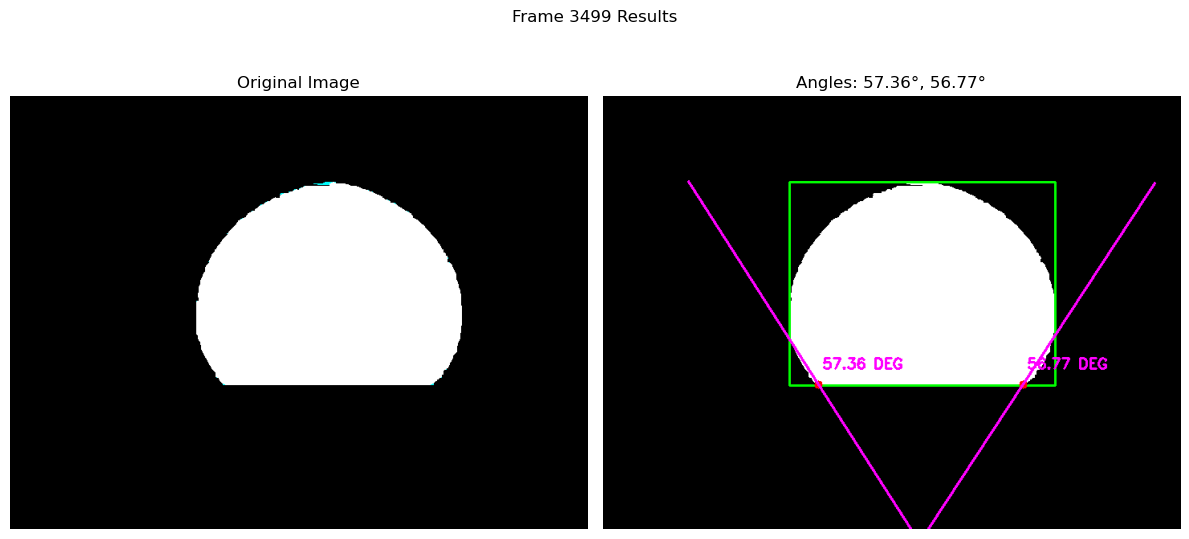

Frame 3999: Intersection points = (276,360), (527,360)
            Tangent angles (horizontal) = 56.94°, 56.78°



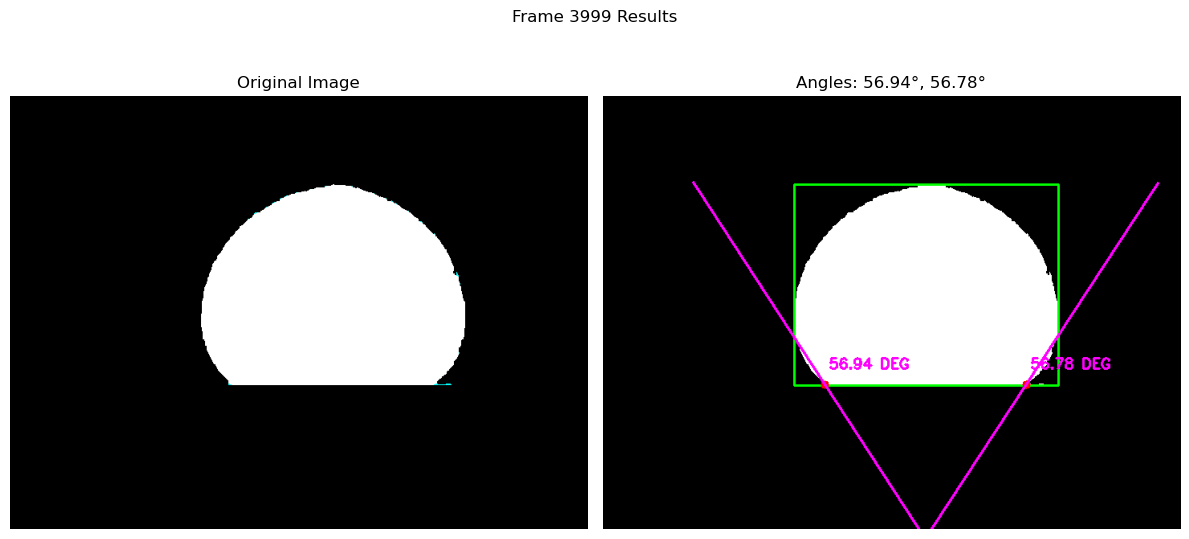

Frame 4499: Intersection points = (321,360), (540,360)
            Tangent angles (horizontal) = 51.44°, 51.97°



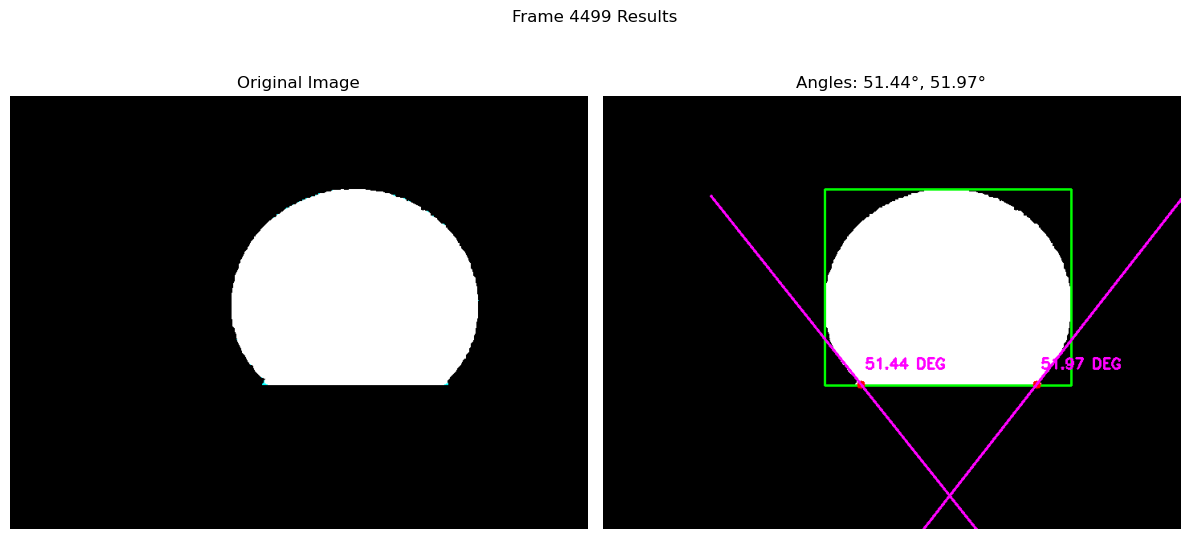

Frame 4999: Intersection points = (324,360), (539,360)
            Tangent angles (horizontal) = 53.92°, 55.31°



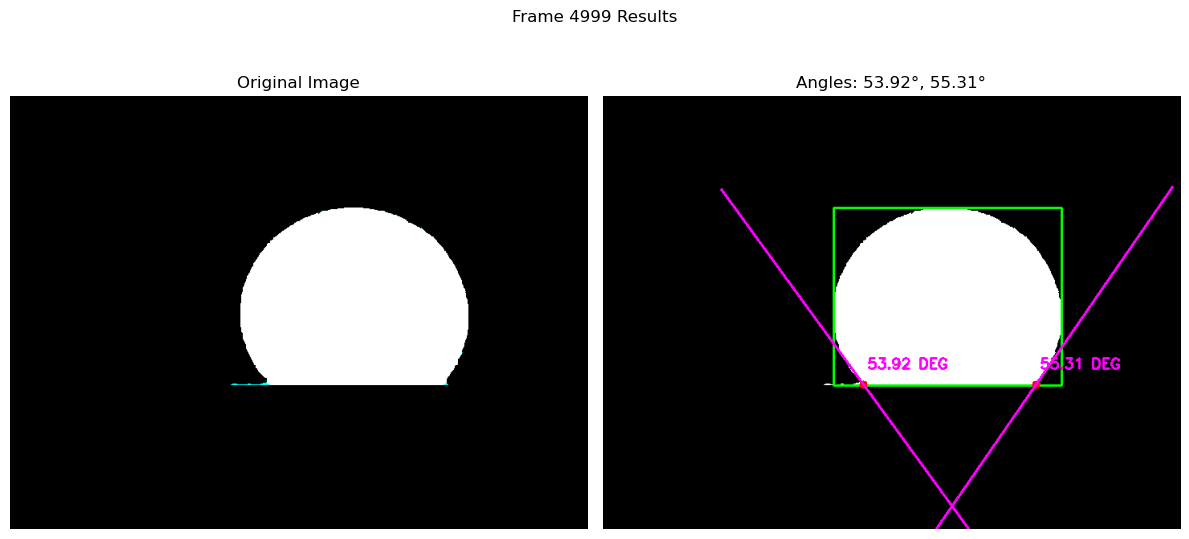

In [ ]:
import cv2
import numpy as np
import os
import glob
import math
import matplotlib.pyplot as plt


def clean_mask_in_memory(mask):
    # 1) Erode
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    eroded = cv2.erode(mask, erode_kernel, iterations=2)  # adjust iterations as needed

    # 2) Largest Connected Component on the eroded mask
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded, connectivity=8)
    if num_labels <= 1:
        return None  # no foreground left

    largest_lbl = 1
    largest_area = stats[1, cv2.CC_STAT_AREA]
    for lbl in range(2, num_labels):
        area = stats[lbl, cv2.CC_STAT_AREA]
        if area > largest_area:
            largest_area = area
            largest_lbl = lbl

    # Keep only the largest region
    eroded_clean = np.where(labels == largest_lbl, 255, 0).astype(np.uint8)

    # 3) Dilate back
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    final = cv2.dilate(eroded_clean, dilate_kernel, iterations=2)

    return final

def compute_tangent_slope(x_pt, y_pt, xc, yc, a, b):
    numerator = -(x_pt - xc) * (b**2)
    denominator = (y_pt - yc) * (a**2)
    if abs(denominator) < 1e-10:
        return None  # vertical tangent
    return numerator / denominator

def compute_angle_from_slope(slope):
    if slope is None:
        return 90.0  # vertical
    return abs(math.degrees(math.atan(slope)))

def filename(index):
    pattern = os.path.join(path, f'frame_{index:03d}*.png')
    files = glob.glob(pattern)
    return files[0] if files else None

# Process frames (0..5000 in steps of 500)
for i in range(0, 5001, 500):
    frame_idx = i if i == 0 else i - 1
    file_path = filename(frame_idx)
    if file_path is None:
        print(f"No file found for frame {frame_idx:03d}. Skipping.\n")
        continue

    # Load grayscale
    img_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        print(f"Failed to load {file_path}. Skipping.\n")
        continue

    # Threshold to binary
    _, thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)

    # Clean the mask (erode -> largest CC -> dilate)
    cleaned = clean_mask_in_memory(thresh)
    if cleaned is None:
        print(f"No foreground found in {frame_idx:03d}")
        continue

    # Compute "removed pixels" mask 
    removed = cv2.bitwise_and(thresh, cv2.bitwise_not(cleaned))

    # Show them over the original mask in color
    left_img = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    # Color the removed pixels in cyan
    left_img[removed == 255] = (255, 255, 0)

    # --- 3) Now proceed with final droplet contour & tangents on the cleaned mask ---
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"No contours found in frame {frame_idx:03d}.\n")
        continue

    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)
    bottom_y = y + h

    # BGR image for bounding box + tangents
    right_img = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(right_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Intersection points near bottom line
    intersection_points = []
    for pt in contour:
        px, py = pt[0]
        if abs(py - bottom_y) <= 1:
            intersection_points.append((px, py))

    if len(intersection_points) < 2:
        print(f"Could not find two intersection points for frame {frame_idx:03d}.\n")
        continue

    intersection_points.sort(key=lambda p: p[0])
    (x1, y1), (x2, y2) = intersection_points[0], intersection_points[-1]

    # Mark them red
    cv2.circle(right_img, (x1, y1), 5, (0, 0, 255), -1)
    cv2.circle(right_img, (x2, y2), 5, (0, 0, 255), -1)

    # Fit ellipse
    if len(contour) < 5:
        print(f"Not enough contour points to fit ellipse for frame {frame_idx:03d}.\n")
        continue

    ellipse = cv2.fitEllipse(contour)
    (xc, yc), (major, minor), ell_angle = ellipse
    a = major / 2.0
    b = minor / 2.0

    slope1 = compute_tangent_slope(x1, y1, xc, yc, a, b)
    slope2 = compute_tangent_slope(x2, y2, xc, yc, a, b)
    angle1 = compute_angle_from_slope(slope1)
    angle2 = compute_angle_from_slope(slope2)

    def draw_tangent(img, x_pt, y_pt, slope, length=300):
        if slope is None:
            x1_ = x2_ = x_pt
            y1_ = y_pt - length
            y2_ = y_pt + length
        else:
            inv_len = length / math.sqrt(1 + slope**2)
            x1_ = int(x_pt + inv_len)
            y1_ = int(y_pt + slope * (x1_ - x_pt))

            x2_ = int(x_pt - inv_len)
            y2_ = int(y_pt + slope * (x2_ - x_pt))

        cv2.line(img, (x1_, y1_), (x2_, y2_), (255, 0, 255), 2)

    # Draw tangents
    draw_tangent(right_img, x1, y1, slope1)
    draw_tangent(right_img, x2, y2, slope2)

    # Put angles
    cv2.putText(right_img, f"{angle1:.2f} DEG", (x1 + 5, y1 - 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)
    cv2.putText(right_img, f"{angle2:.2f} DEG", (x2 + 5, y2 - 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)

    # Print angles
    print(f"Frame {frame_idx:03d}: Intersection points = ({x1},{y1}), ({x2},{y2})")
    print(f"            Tangent angles (horizontal) = {angle1:.2f}°, {angle2:.2f}°\n")

    # Show results side by side
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Frame {frame_idx:03d} Results')

    # Left: Original mask with REMOVED lumps in cyan
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Right: bounding box + tangents
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Angles: {angle1:.2f}°, {angle2:.2f}°')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
